In [1]:
%pwd
%cd ..

/media/yana/discD/projects/farich-pics


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from farichlib.DataPreprocessing import DataPreprocessing
from farichlib.DataPreprocessing import print_board
from farichlib.utils import iou_score
import numpy as np
import os
import pickle

%cd data/rootfiles

/media/yana/discD/projects/farich-pics/data/rootfiles


In [4]:
folder_root = '.'
rootfiles = [f for f in os.listdir(folder_root) if os.path.isfile(os.path.join(folder_root, f))]
rootfiles

['farichSimRes_e-mu-_1000MeV_15-90deg_30.0k_2020-02-07.root',
 'farichSimRes_e-mu-_3000MeV_0-90deg_30.0k_2020-02-07.root',
 'farichSimRes_pi-kaon-_1000MeV_0-90deg_50.0k_2020-02-11.root']

In [5]:
dp = DataPreprocessing()
dp.parse_root(rootfiles[1])

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from matplotlib.patches import Ellipse, Circle

%matplotlib inline

In [161]:
!pip install iminuit

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 4.0 MB 130 kB/s eta 0:00:01     |████████████                    | 1.5 MB 190 kB/s eta 0:00:14


In [7]:
from iminuit import Minuit

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Анализ для одного эллипса

In [9]:
def X_t(t, ax0, ax1, bx1):
    return ax0 + ax1*np.cos(t) + bx1*np.sin(t)
def Y_t(t, ay0, ay1, by1):
    return ay0 + ay1*np.cos(t) + by1*np.sin(t)
def XY(t, pars):
    return np.array( [X_t(t, *pars[:3]), Y_t(t, *pars[3:])] )

In [29]:
#def step(x, y, ax0, ax1, bx1, ay0, ay1, by1, alpha=0.1, beta=0.00):
#    t = np.arctan2((y - ay0), (x - ax0))
#    dx, dy = x - X_t(t, ax0, ax1, bx1), y - Y_t(t, ay0, ay1, by1)
#    d = np.sqrt( dx**2 + dy**2 )
#    d = np.where(d > 5, d, 5/2.)
#    grad = ( -dx/d, -dy/d )
#    dax0, day0 = grad[0], grad[1]
#    dax1, day1 = grad[0]*np.cos(t), grad[1]*np.cos(t)
#    dbx1, dby1 = grad[0]*np.sin(t), grad[1]*np.sin(t)
#    dax0, day0, dax1, day1, dbx1, dby1 = np.sum(dax0), np.sum(day0), \
#    np.sum(dax1), np.sum(day1), np.sum(dbx1), np.sum(dby1)
#    ax0, ay0, ax1, ay1, bx1, by1 = ax0-alpha*dax0, ay0-alpha*day0, ax1-alpha*dax1, \
#    ay1-(alpha+2*beta)*day1, bx1-(alpha+2*beta)*dbx1, by1-alpha*dby1
#    return ax0, ax1, bx1, ay0, ay1, by1

In [30]:
#ax0, ax1, bx1, ay0, ay1, by1 = 30, 15, 0, 50, 0, 5
#for epoch in range(100):
#    ax0, ax1, bx1, ay0, ay1, by1 = step(x, y, ax0, ax1, bx1, ay0, ay1, by1, alpha=0.1)
#    print( np.array( [ax0, ax1, bx1, ay0, ay1, by1] ).round(2) )

In [10]:
det_sigm = 5

In [11]:
def Energy_function(ax0, ax1, bx1, ay0, ay1, by1):
    t = np.arctan2((y - ay0), (x - ax0))
    Xt = X_t(t, ax0, ax1, bx1)
    Yt = Y_t(t, ay0, ay1, by1)
    dist = np.sqrt((x-Xt)**2 + (y-Yt)**2)
    sigm = np.where(dist > det_sigm, dist, det_sigm)
    return np.sum( dist**2/sigm )

In [13]:
loc_ind = 10
#loc_ind += 1
x = dp.X[loc_ind].row
y = dp.X[loc_ind].col
xv, yv, r = dp.y[loc_ind]
xv, yv, r

(32.0, 38.0, 16.0)

In [14]:
m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, 
           limit_ax0=[0,63], limit_ay0=[0,135], limit_bx1=[0,0], limit_ay1=[0,0])
m.migrad()

------------------------------------------------------------------
| FCN = 96.05                   |     Ncalls=107 (107 total)     |
| EDM = 3.01E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | ax0  |   32.0    |    0.5    |            |            |    0    |   63    |       |
| 1 | ax1  |   16.2    |    0.5    |            |            |         |         |       |
| 2 | bx1  |    0.0    |    1.0    |            |            |         |         |  yes  |
| 3 | ay0  |   38.2    |    0.5    |            |            |    0    |   135   |       |
| 4 | ay1  |    0.0    |    1.0    |            |            |         |         |  yes  |
| 5 | by1  |   16.5    |    0.5    |            |            |         |         |       |
------------------------------------------------------------------------------------------

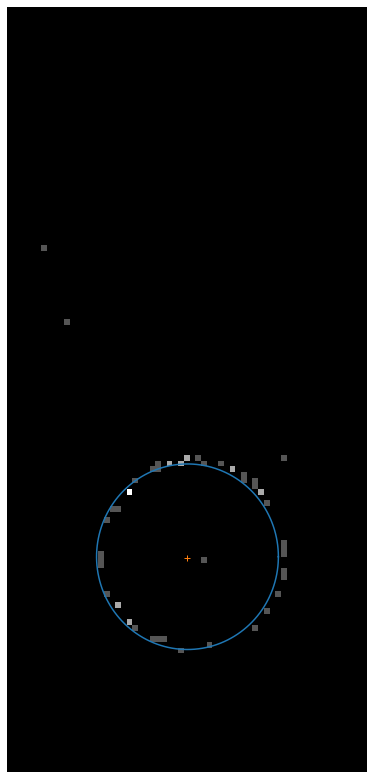

In [15]:
t = np.linspace(0, 2*np.pi, 300)
xx, yy = XY(t, m.np_values())
#xx, yy = XY(t, np.array([ax0, ax1, bx1, ay0, ay1, by1]))

H = dp.X[loc_ind].toarray()
xedges = np.linspace(0, H.shape[0], H.shape[0])
yedges = np.linspace(0, H.shape[1], H.shape[1])
fig = plt.figure(frameon=False, figsize=(5, 5) )
ax = plt.Axes(fig, [0., 0., 1., H.shape[1]/H.shape[0]])
ax.set_axis_off()
fig.add_axes(ax)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H.T, cmap='gray')
plt.plot(xx, yy)
#xv, yv = ax0, ay0
plt.plot(xv, yv, '+')

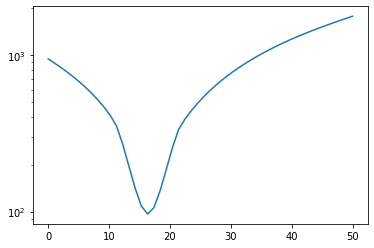

In [16]:
rr = np.linspace( 0, 50, 50)
#ax0, ax1, bx1, ay0, ay1, by1, w0, w1
#xv = 32
#yv = 37
#rs = [least_func(xv, r, 0, yv, 0, r) for r in rr]
rs = [Energy_function(xv, r, 0, yv, 0, r) for r in rr]
plt.plot(rr, rs)
plt.yscale('log')

## Посмотрим на время вычисления и на метрики

In [17]:
%timeit m.migrad()

1.71 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%time
m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, limit_ax0=[0,63], limit_ay0=[0,135])
m.migrad()

CPU times: user 14.1 ms, sys: 82 µs, total: 14.1 ms
Wall time: 12.9 ms


------------------------------------------------------------------
| FCN = 96.02                   |     Ncalls=171 (171 total)     |
| EDM = 6.26E-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | ax0  |   32.0    |    0.5    |            |            |    0    |   63    |       |
| 1 | ax1  |   16.2    |    0.5    |            |            |         |         |       |
| 2 | bx1  |   0.06    |   0.43    |            |            |         |         |       |
| 3 | ay0  |   38.3    |    0.5    |            |            |    0    |   135   |       |
| 4 | ay1  |   0.05    |   0.48    |            |            |         |         |       |
| 5 | by1  |   16.5    |    0.5    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [291]:
H_all, h_all, mask_all = dp.generate_boards(board_size=100, N_circles=1, N_boards=1000)

0


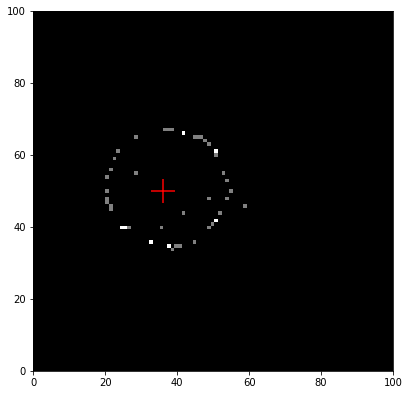

In [292]:
print_board(H_all[0], h_all[0])

In [293]:
def iou_score(m, h, H):
    # now only for circles
    ax0, ax1, bx1, ay0, ay1, by1 = m.np_values()
    xx = np.linspace(0, H.shape[0], H.shape[0])
    yy = np.linspace(0, H.shape[1], H.shape[1]).reshape((-1, 1))
    mask_minuit = ((xx-ax0)**2)/(ax1**2) + ((yy-ay0)**2)/(by1**2) <= 1 
    mask_sim = np.array([])
    for i in range(h.shape[0]):
        xv, yv, rv = h[i]
        circle = (xx - yv)**2 + (yy - xv)**2 <= rv**2
        mask_sim = np.append(mask_sim, circle)
    mask_sim = mask_sim.reshape((-1, H.shape[0], H.shape[1]))
    masks_minuit = np.broadcast_to(mask_minuit, mask_sim.shape)
    inter = np.logical_and(mask_sim, masks_minuit).sum(axis=(1,2))
    union = np.logical_or(mask_sim, masks_minuit).sum(axis=(1,2))
    return inter/union

In [294]:
rr = []
for index in range(1000):
    x = H_all[index].row
    y = H_all[index].col
    H = H_all[index].toarray()
    h = h_all[index]
    m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, limit_ax0=[0,63], limit_ay0=[0,135])
    m.migrad()
    rr.append( iou_score(m, h, H) )
    
rr = np.array( rr )

In [295]:
rr.mean()

0.8675463065141185

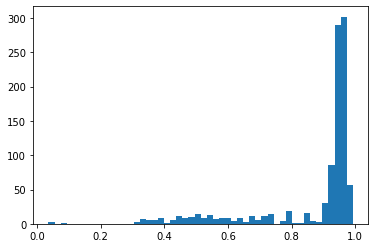

In [296]:
plt.hist(rr, 50);

### Посмотрим, что будет для нескольких кругов 

In [297]:
H_all, h_all, mask_all = dp.generate_boards(board_size=100, N_circles=2, N_boards=1000)

0


In [305]:
rr = []
for index in range(1000):
    x = H_all[index].row
    y = H_all[index].col
    H = H_all[index].toarray()
    #h = h_all[index][0].reshape(-1,3)
    h = h_all[index]
    m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, limit_ax0=[0,63], limit_ay0=[0,135])
    m.migrad()
    rr.append( max( iou_score(m, h, H) ) )
rr = np.array( rr )

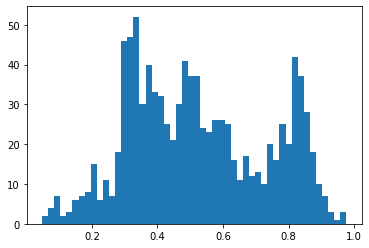

In [308]:
plt.hist(rr, 50);

In [276]:
%timeit m.migrad()

1.21 ms ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [290]:
%%time
m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, limit_ax0=[0,63], limit_ay0=[0,135])
m.migrad()

CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 15.2 ms


------------------------------------------------------------------
| FCN = 14.48                   |     Ncalls=284 (284 total)     |
| EDM = 3.72E-07 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | ax0  |   24.3    |    0.6    |            |            |    0    |   63    |       |
| 1 | ax1  |   16.2    |    0.6    |            |            |         |         |       |
| 2 | bx1  |   -0.04   |    0.51   |            |            |         |         |       |
| 3 | ay0  |   35.7    |    0.5    |            |            |    0    |   135   |       |
| 4 | ay1  |   -0.04   |    0.57   |            |            |         |         |       |
| 5 | by1  |   16.2    |    0.5    |            |            |         |         |       |
------------------------------------------------------------------------------------------

# Теперь сравним результат классического алгоритма и нейросети. Для этого построим распределение по IoU-скору для одинаковых картинок при фиксированному порогу нейросети (то есть тому порогу, которому мы бы хотели использовать в экспериментре)

In [311]:
import torchvision
import math
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model(load_trained=None):
    if load_trained is None:
        num_classes = 2
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        return model
    return torch.load(load_trained)

In [310]:
path_nn = 'media/yana/discD/projects/farich-pics/data/CirclesNN_210420.pth'

In [312]:
model = get_model(path_nn) #use pretrained model on noiseless data

NameError: name 'torch' is not defined